# 1. Imports and constants

!!! Virtual environment has to be installed first. Follow the installation guide in README.md file

In [1]:
import os
# solves GPU memory allocation while using 2 LLMs
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"]="false"
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]=".40"
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"]="platform"

import cv2
from glob import glob
from os.path import basename

import numpy as np
import pandas as pd
import base64

import tensorflow as tf
import torch

from IPython.display import Video
from IPython.display import display, Image, HTML

import chatgpt as gpt
import MobileNet as mn
import VideoCutter as vc

import paligemma as pg
import florence as fl


tf.get_logger().setLevel('ERROR')
os.environ['CUDA_DEVICE_QUIET']='1'

video_path='./tmp/video.mp4'
repr_path='./tmp/representations/' # path where the most distinctive representations of facilites will be extracted and stored

# function for future VLLM use
def prep_test_df():
    files = [(basename(x).split('_')[0], x) for x in glob(repr_path + '/*.jpg')]
    df = pd.DataFrame(files, columns=['class', 'file_name'])
    df=pd.merge(df, gpt.QUESTIONS, on='class')
    df['gpt_reply']=''
    return df

2024-08-19 09:08:31.672122: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-19 09:08:31.680140: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-19 09:08:31.689408: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-19 09:08:31.692039: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-19 09:08:31.698994: I tensorflow/core/platform/cpu_feature_guar

[cuda(id=0)]
JAX backend: gpu
JAX version:  0.4.28
JAX platform: gpu
JAX devices:  1


I0000 00:00:1724022514.423321    8053 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1724022514.423496    8053 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1724022514.423553    8053 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


### Sample video and models' weights download

In [6]:
!rm -r ./tmp
!mkdir ./tmp
!mkdir ./tmp/representations
!wget -O ./tmp/video.mp4 'https://www.dropbox.com/scl/fi/6t0hiqqkbqik8imx9mj8b/Video3080_10May2024.mp4?rlkey=h154to87uaubx12mq7cz8mclk&st=tlx709ju&dl=0'
# !wget -O model.pt 'https://www.dropbox.com/scl/fi/uypcm06fviynhpbgmmxy4/draft.pt?rlkey=9np26uc11lbzni7wfgds1n5ly&dl=0'


--2024-08-18 22:40:34--  https://www.dropbox.com/scl/fi/6t0hiqqkbqik8imx9mj8b/Video3080_10May2024.mp4?rlkey=h154to87uaubx12mq7cz8mclk&st=tlx709ju&dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.83.18, 2620:100:6033:18::a27d:5312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.83.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uc2b8fd6575d83339c3ebd141f5d.dl.dropboxusercontent.com/cd/0/inline/CY27qQL2Vh8J03Xw-GFJZYJB9KIKNhSb92g3XUoGwdbmvW6ucA4ckd7B-9BjG2i6iiZU-GwdZyXyF9AjtaDdBM6j0yE75YxEPZSQELqheTF8MXr2vDdFYcfIKB6gGcXK2ss/file# [following]
--2024-08-18 22:40:35--  https://uc2b8fd6575d83339c3ebd141f5d.dl.dropboxusercontent.com/cd/0/inline/CY27qQL2Vh8J03Xw-GFJZYJB9KIKNhSb92g3XUoGwdbmvW6ucA4ckd7B-9BjG2i6iiZU-GwdZyXyF9AjtaDdBM6j0yE75YxEPZSQELqheTF8MXr2vDdFYcfIKB6gGcXK2ss/file
Resolving uc2b8fd6575d83339c3ebd141f5d.dl.dropboxusercontent.com (uc2b8fd6575d83339c3ebd141f5d.dl.dropboxusercontent.com)... 162.125.83.15, 2620:100:6033:15

In [7]:
from IPython.display import HTML
HTML(f"""
<video width="320" height="240" controls>
  <source src="{video_path}" type="video/mp4">
</video>
""")

# 2. Extract sharp images with unique representations of each facility we assess

In [2]:
os.makedirs(repr_path,exist_ok=True)
reprs=vc.cutVideo(video_path, output_path=repr_path)

/ML/Common/envs/foodn/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'SGD', because it has 2 variables whereas the saved optimizer has 6 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
100%|█████████▉| 1286/1287 [01:02<00:00, 20.62it/s]


62.36553072929382


2024-08-19 00:36:27.271171: E tensorflow/core/util/util.cc:131] oneDNN supports DT_HALF only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.
I0000 00:00:1723991787.279810  174112 service.cc:146] XLA service 0x7fa8f0005850 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1723991787.279832  174112 service.cc:154]   StreamExecutor device (0): Host, Default Version
2024-08-19 00:36:27.304861: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1723991787.958294  174112 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 699ms/step
6.881399869918823


### Now, let us examine the most distinctive representations that were extracted from the video:

DW



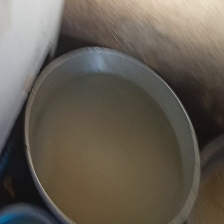
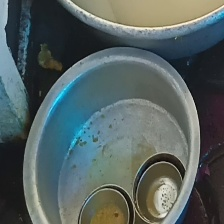
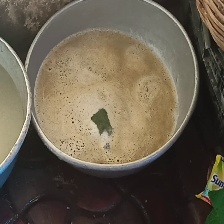
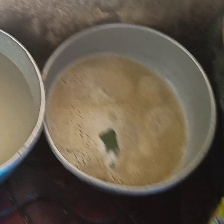
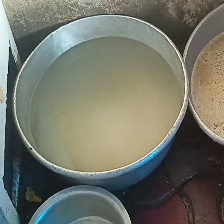

GB



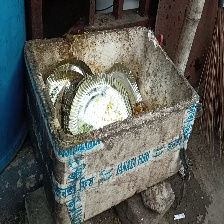
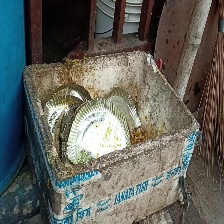
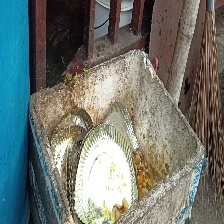
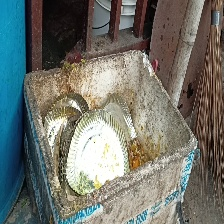
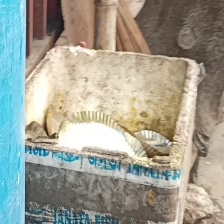

WP



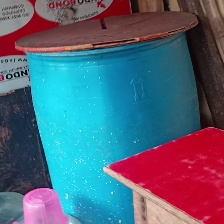
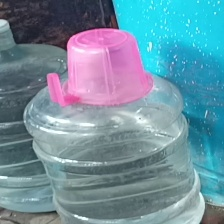
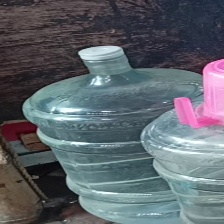
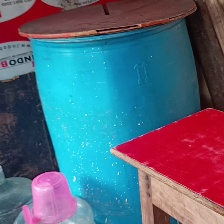
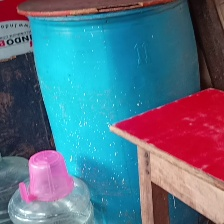

In [2]:
def image_to_base64(image_path):
    with open(image_path, "rb") as img_file:
        return base64.b64encode(img_file.read()).decode('utf-8')

def display_reprs(image_paths):
    image_html = ''.join([f'<img src="data:image/png;base64,{image_to_base64(img)}" style="display:inline-block; margin-right:10px; width:200px;">' for img in image_paths])
    display(HTML(image_html))


files = [(basename(x).split('_')[0],x) for x in glob(repr_path+'/*.jpg')]
df=pd.DataFrame(files,columns=['class','file_name'])
dfg=df.groupby(by='class')
for g,gr in dfg:
    print(g)
    display_reprs(gr['file_name'].values)

#### As we can see, the pipeline chose unique objects: each individual Dishwasher boul, and each watertank is captured. All the images extracted are clear (no motion blur), and we also get various perspectives (angles) of the objects for deep analysis.

# 3. VLLM analysis


## Display results functions

In [3]:
import utils
import io

from IPython.display import HTML, display
def display_image_and_text(image_path, text):
    # Convert the image to a base64 string
    with open(image_path, "rb") as img_file:
        image_base64 = base64.b64encode(img_file.read()).decode('utf-8')

    formatted_text = text.replace("\n", "<br>")
    
    html_code = f"""
    <div style="display: flex; align-items: center;">
        <div style="flex: 1;">
            <img src="data:image/png;base64,{image_base64}" style="max-width: 100%; height: auto;">
        </div>
        <div style="flex: 1; padding-left: 20px;">
            <p style="font-size: 14px;">{formatted_text}</p>
        </div>
    </div>
    """
    
    display(HTML(html_code))

def load_and_display_results(file_name):
    df=pd.read_csv(f'./tmp/{file_name}')
    df=df.sort_values(by=['file_name','dcode'])
    dfg=df.groupby(by='file_name')
    for file_path,gr in dfg:
        text=''
        for i in range(gr.shape[0]):
            row=gr.iloc[i,:]
            dcode=row['dcode']
            question=gpt.QUESTIONS[gpt.QUESTIONS['dcode']==dcode]['question'].values[0]
    
            text+=question+'\n'+row['reply']+'\n'+'\n'
        display_image_and_text(repr_path+file_path, text)

## Paligemma inference

In [4]:
pg.create_food_safety_dataset(val_df=prep_test_df())
mod_name='v2_foodSafety_PaliGemma-3b-224px_150000ex_bf16'
pg.prepare_model(mod_name)
preds=pg.food_safety_predictions()
preds['short_answer']=[gpt.extract_short_answer(x) for ii,x in enumerate(preds['reply'])]
preds.to_csv('./tmp/paligemma.csv',index=None)
pg.clear_memory()


done
 == Model params == 
img/Transformer/encoder_norm/bias                                                (1152,)                float32
img/Transformer/encoder_norm/scale                                               (1152,)                float32
img/Transformer/encoderblock/LayerNorm_0/bias                                    (27, 1152)             float32
img/Transformer/encoderblock/LayerNorm_0/scale                                   (27, 1152)             float32
img/Transformer/encoderblock/LayerNorm_1/bias                                    (27, 1152)             float32
img/Transformer/encoderblock/LayerNorm_1/scale                                   (27, 1152)             float32
img/Transformer/encoderblock/MlpBlock_0/Dense_0/bias                             (27, 4304)             float32
img/Transformer/encoderblock/MlpBlock_0/Dense_0/kernel                           (27, 1152, 4304)       float32
img/Transformer/encoderblock/MlpBlock_0/Dense_1/bias                          

2024-08-19 09:10:43.976413: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Paligemma prediction. Time taken: 21.091001749038696



### Show Paligemma's results


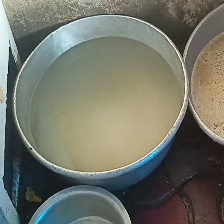


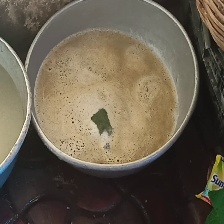


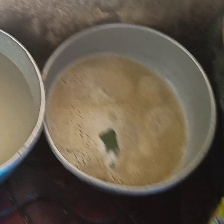


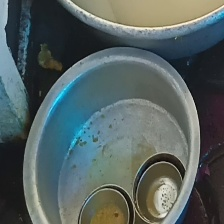


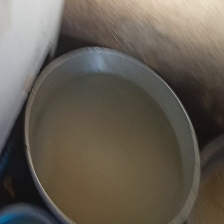


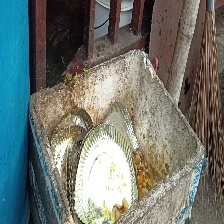


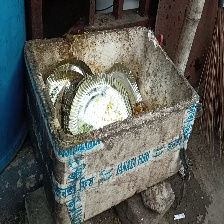


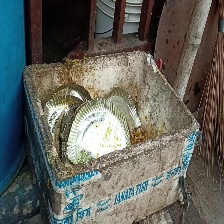


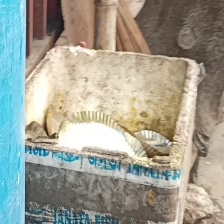


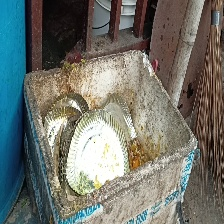


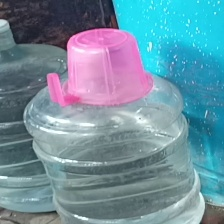


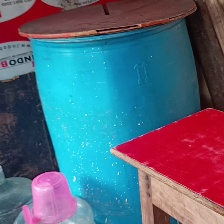


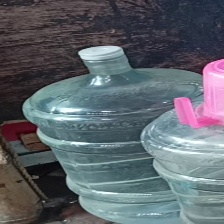


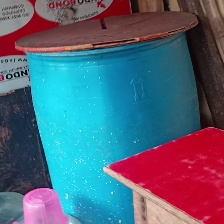


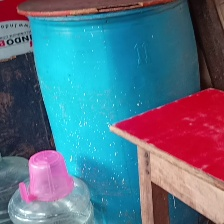

In [5]:
load_and_display_results('paligemma.csv')

## Florence-2 inference

In [6]:
preds=fl.predict_dataframe(prep_test_df())
preds.to_csv('./tmp/florence2.csv',index=None)
torch.cuda.empty_cache()

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Florence2 prediction time: 4.4491002559661865


### Show Florence-2 results


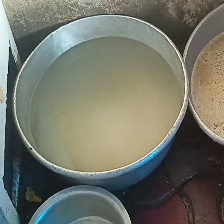


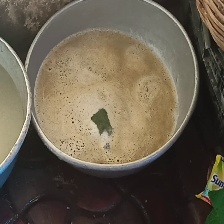


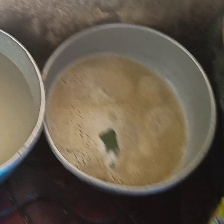


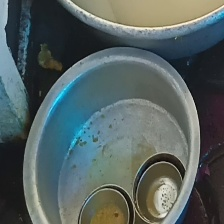


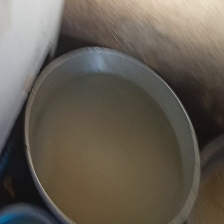


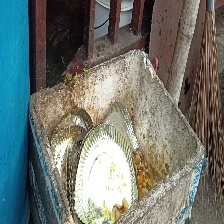


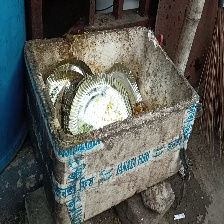


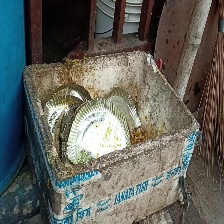


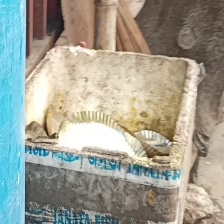


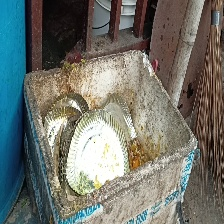


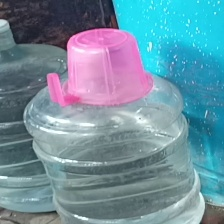


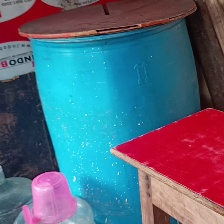


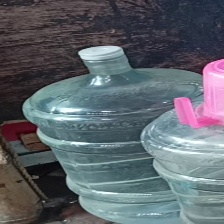


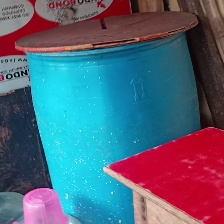


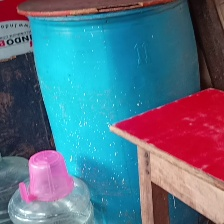

In [7]:
load_and_display_results('florence2.csv')